In [1]:
import pandas as pd
import requests
import zipfile
import io, os
import openpyxl
from pathlib import Path
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib
import seaborn

## Podział pracy:
* zad 2 i 3: Maja Domańska
* zad 1 i 4: Joanna Huba

## wczytanie danych

In [2]:
DATA_DIR = Path("../data/processed")

df_ex2 = pd.read_csv(DATA_DIR / "df_ex2.csv")
df_ex4 = pd.read_csv(DATA_DIR / "df_ex4.csv")
monthly_PM25 = pd.read_csv(DATA_DIR / "monthly_PM25.csv")

# 2. Średnie miesięczne + trend dla miast

In [2]:
from pathlib import Path
import pandas as pd
import sys

from z03_monthly_trends import make_trend_df, trend_sanity_summary

DATA_DIR = Path("../data/processed")
df_ex2 = pd.read_csv(DATA_DIR / "df_ex2.csv")

trend_df = make_trend_df(df_ex2, years=(2015, 2024))

summary = trend_sanity_summary(trend_df)
print("Lata w trend_df:", summary["years_present"])
print("Miasta w trend_df:", summary["cities_present"])

print("\nLiczba miesięcy w trend_df (miasto × rok):")
display(summary["months_per_city_year"])

print("\nŚrednie PM2.5 dla każdego miasta i roku w trend_df:")
display(summary["mean_pm25_city_year"])

display(trend_df.head(10))


Lata w trend_df: [2015, 2024]
Miasta w trend_df: ['Katowice', 'Warszawa']

Liczba miesięcy w trend_df (miasto × rok):


year,2015,2024
city,,
Katowice,7,12
Warszawa,8,12



Średnie PM2.5 dla każdego miasta i roku w trend_df:


city      year
Katowice  2015    39.267960
          2024    18.513139
Warszawa  2015    26.852051
          2024    14.636462
Name: PM2.5, dtype: float64

,year,month,city,PM2.5
0,2015,1,Katowice,44.549000
1,2015,2,Katowice,19.860900
2,2015,3,Katowice,33.920467
3,2015,5,Katowice,81.653400
4,2015,8,Katowice,41.198750
5,2015,9,Katowice,17.189000
6,2015,11,Katowice,36.504200
7,2024,1,Katowice,22.559091
8,2024,2,Katowice,15.224101
9,2024,3,Katowice,14.864236


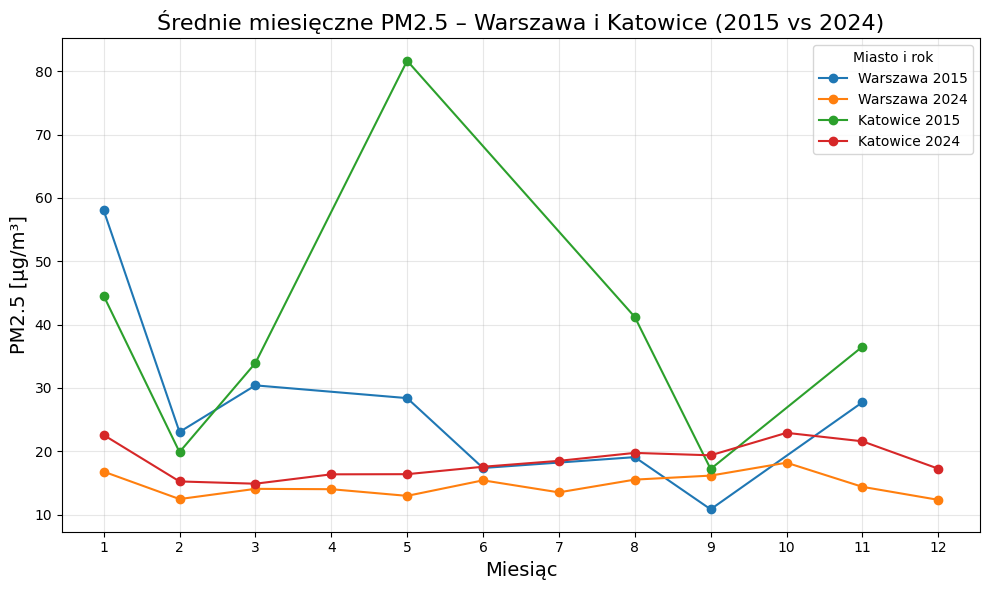

In [5]:
# wykres
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

cities = ["Warszawa", "Katowice"]
years_to_plot = [2015, 2024]

for city in cities:
    for y in years_to_plot:
        sub = trend_df[(trend_df["city"] == city) & (trend_df["year"] == y)]
        plt.plot(
            sub["month"],
            sub["PM2.5"],
            marker="o",
            label=f"{city} {y}"
        )

plt.title("Średnie miesięczne PM2.5 – Warszawa i Katowice (2015 vs 2024)", fontsize=16)
plt.xlabel("Miesiąc", fontsize=14)
plt.ylabel("PM2.5 [µg/m³]", fontsize=14)
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.legend(title="Miasto i rok")
plt.tight_layout()
plt.show()

### Obserwacje i interpretacja:
- Zarówno w 2014, jak i w 2024 roku **najniższe wartości występują latem (maj–sierpień), a najwyższe zimą**, co wiąże się z intensywniejszym ogrzewaniem budynków i większym zużyciem paliw stałych.
- W **Warszawie** zimowe wartości w 2014 roku są znacznie wyższe niż w 2024, co wskazuje na wyraźną poprawę jakości powietrza w ciągu analizowanej dekady.
- W **Katowicach** poziomy PM2.5 zimą są ogólnie wyższe niż w Warszawie, ale w 2024 roku też obserwujemy istotny spadek względem 2014.
- W miesiącach letnich stężenia PM2.5 są niskie i stosunkowo stabilne w obu latach, a różnice między 2014 i 2024 są dużo mniejsze niż zimą.

Porównanie lat 2014 i 2024 wskazuje na **wyraźną poprawę jakości powietrza**, szczególnie w sezonie grzewczym.  
W obu miastach średnie miesięczne stężenia PM2.5 zmalały, co sugeruje skuteczność działań ograniczających emisję zanieczyszczeń. 
Mimo poprawy, **Katowice nadal są bardziej zanieczyszczone niż Warszawa**.

## 3. Heatmapa miesięcznych średnich

In [14]:
# Przygotowanie danych
df_ex3 = (
    monthly_PM25
    .groupby(["city", "year", "month"], as_index=False)[["PM2.5"]]
    .mean()
)

cities_ex3 = (
    df_ex3.groupby("city")["year"].nunique()
    .pipe(lambda s: s[s == 4].index.tolist())
)

# sanity checks:
print("Miejscowości z kompletnymi danymi:", cities_ex3)
print("Lata w df_ex3:", sorted(df_ex3["year"].unique()))
print("Liczba miejscowości w df_ex3:", df_ex3["city"].nunique())
print("\nLiczba lat dla każdego miasta:")
display(
    df_ex3.groupby("city")["year"].nunique()
)
print("\nZakres wartości PM2.5 w df_ex3:")
print("min =", df_ex3["PM2.5"].min(), "max =", df_ex3["PM2.5"].max())

Miejscowości z kompletnymi danymi: ['Białystok', 'Bydgoszcz', 'Jelenia Góra', 'Kalisz', 'Katowice', 'Kraków', 'Kędzierzyn-Koźle', 'Legionowo', 'Lublin', 'Olsztyn', 'Piastów', 'Przemyśl', 'Płock', 'Radom', 'Siedlce', 'Warszawa', 'Wrocław', 'Zgierz', 'Zielona Góra', 'Złoty Potok', 'Łódź', 'Żyrardów']
Lata w df_ex3: [np.int64(2015), np.int64(2018), np.int64(2021), np.int64(2024)]
Liczba miejscowości w df_ex3: 22

Liczba lat dla każdego miasta:


city
Białystok           4
Bydgoszcz           4
Jelenia Góra        4
Kalisz              4
Katowice            4
Kraków              4
Kędzierzyn-Koźle    4
Legionowo           4
Lublin              4
Olsztyn             4
Piastów             4
Przemyśl            4
Płock               4
Radom               4
Siedlce             4
Warszawa            4
Wrocław             4
Zgierz              4
Zielona Góra        4
Złoty Potok         4
Łódź                4
Żyrardów            4
Name: year, dtype: int64


Zakres wartości PM2.5 w df_ex3:
min = 3.7 max = 206.839


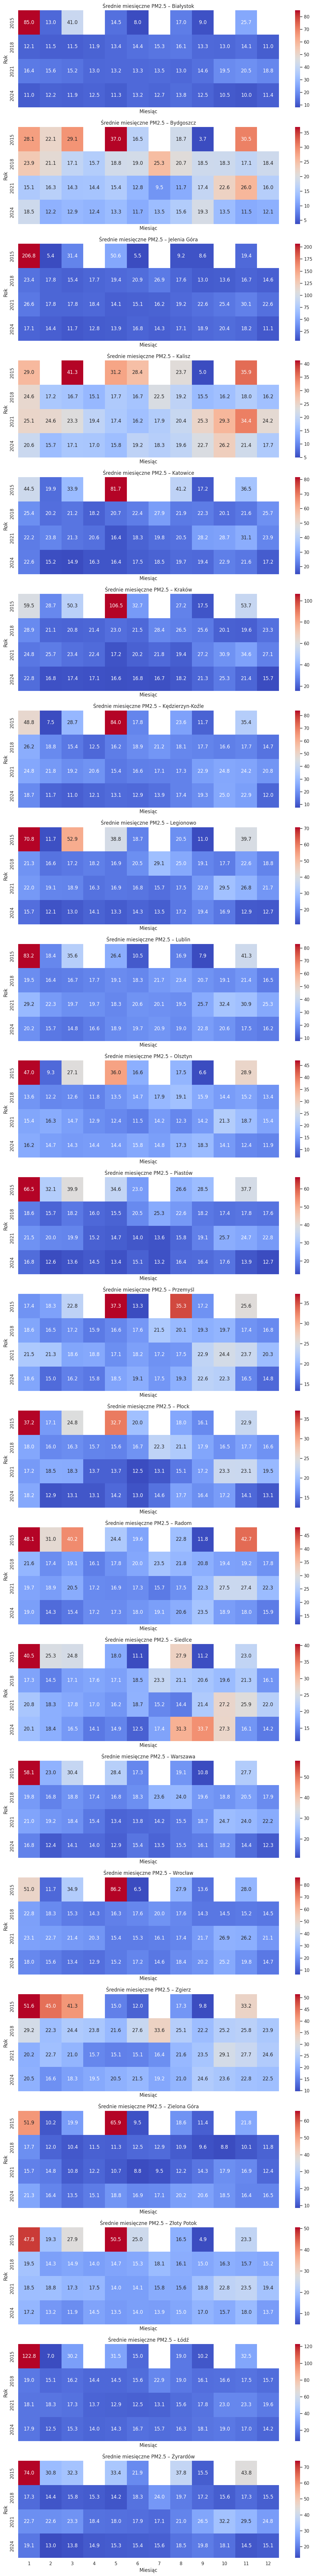

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Tworzenie tyle paneli ile jest miejscowości:
fig, axes = plt.subplots(
    nrows=len(cities_ex3),
    ncols=1,
    figsize=(12, 4 * len(cities_ex3)),
    sharex=True
)

# tworzenie heatmapy dla każdej miejscowości:
for ax, city in zip(axes, cities_ex3):
    data = df_ex3[df_ex3["city"] == city]
    heatmap_data = data.pivot(
        index="year",
        columns="month",
        values="PM2.5"
    )
    heatmap_data = heatmap_data.astype(float)

    # Rysowanie: 
    sns.heatmap(
        heatmap_data,
        ax=ax,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        cbar=True
    )

    ax.set_title(f"Średnie miesięczne PM2.5 – {city}")
    ax.set_xlabel("Miesiąc")
    ax.set_ylabel("Rok")

plt.tight_layout()
plt.show()

### Obserwacje i interpretacja:
- We wszystkich analizowanych miastach najniższe stężenia PM2.5 występują latem, a najwyższe zimą, co wynika z sezonu grzewczego.
- W 2014 roku we wszystkich miastach wartości stężenia PM2.5 są najwyższe.
- W 2019 roku widać już wyraźne rozjaśnienie w zimowych miesiącach, co oznacza częściową poprawę jakości powietrza.
- W 2024 roku stężenia zimą są w większości miast dużo niższe niż w poprzednich latach.
- Letnie miesiące mają zbliżone, niskie poziomy PM2.5 we wszystkich latach, a różnice między latami 2014–2024 są tu znacznie mniejsze niż zimą.

Heatmapy z lat 2014, 2019 i 2024 pokazują poprawę jakości powietrza, szczególnie w sezonie zimowym.
Wszystkie miasta wykazują spadek zimowych wartości PM2.5, co wskazuje na skuteczność działań antysmogowych.
Mimo poprawy, we wszystkich miejscowościach zima pozostaje okresem najgorszej jakości powietrza.


## 4. Dni z przekroczeniem normy (WHO)

In [16]:
pio.renderers.default = "jupyterlab"
pio.renderers.default = "notebook_connected"

# Pick 6 stations based on 2024
df_2024 = df_ex4[df_ex4["year"] == 2024]
top3 = df_2024.nlargest(3, "exceeded")
bottom3 = df_2024.nsmallest(3, "exceeded")
stations_6 = pd.concat([top3, bottom3])["station"].unique()

# Filter full data for these stations
top_low_df = df_ex4[df_ex4["station"].isin(stations_6)].copy()

# Prepare plot
station_groups = top_low_df["station"].unique()
years = sorted(top_low_df["year"].unique())
years = top_low_df["year"].unique()

bars = []
colors = ['#7FB3D5',
          '#1F618D',
          '#F4D03F',
          '#C0392B',
          '#008080',
          '#40B0A6']

 
# Generate bars: one color group
for i, station in enumerate(station_groups):
    df = top_low_df[top_low_df["station"] == station]
    bar = go.Bar(
        x=df["year"],
        y=df["exceeded"],
        name=station, 
        marker=dict(color=colors[i])
    )
    bars.append(bar)

# Create figure
fig = go.Figure(data=bars)
fig.update_layout(
    font=dict(
        family="Liberation Serif",  
        size=20,                 
        color="#2C3E50"            
    ),
    barmode='group',
    title=dict(
        text="Dni z przekroczeniem normy (WHO)",
        x=0.5, 
        xanchor='center',
        font=dict(
            family="Liberation Serif",  
            size=35,
            color="#2C3E50"
        )
    ),
    xaxis_title="Rok",
    yaxis_title="Liczba przekroczonych dni",
)
fig.write_html("exceeded_days_plot.html")
fig.show()

## Analiza
Na podstawie wykresu można zauważyć ogólny trend spadkowy liczby dni z przekroczeniem dobowej normy PM2.5 między rokiem 2014 a 2024 dla większości analizowanych stacji. Wskazuje to na poprawę jakości powietrza w badanym okresie.

Warto jednak podkreślić, że nie wszystkie stacje wykazują jednolity spadek w każdym roku. Przykładowo, dla stacji **LdZgieMielcz** obserwujemy wzrost liczby przekroczeń między 2014 a 2019 rokiem, zanim nastąpił ponowny spadek w roku 2024. Oznacza to, że poprawa jakości powietrza nie następowała w tym przypadku w sposób liniowy.

Podsumowując — mimo pewnych wyjątków, najbardziej charakterystycznym wzorcem jest wyraźna redukcja liczby dni z przekroczeniami normy PM2.5 do roku 2024, co sugeruje skuteczniejsze działania antysmogowe i/lub korzystniejsze warunki atmosferyczne.
